##### Setup Imports

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

###### Initialise Styling

In [53]:
%%html
<style>
table {
    position: relative;
    left: 0;
    padding-left: 0;
    margin-left: 0 !important;
}
span {
    font-size:1em;
}
</style>

##### Initialise helper functions

In [54]:
def hist_plot(title, columns, colours, nrows, ncols, index_pos, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3, hspace=0.7):
    """
    Plots a histogram.
    :param title:     The title of the histogram.
    :param columns:   The data columns to plot on the histogram.
    :param colours:   The colours for each data column on the histogram.
    :param nrows:     The number of rows in the presentation table.
    :param ncols:     The number of columns in the presentation table.
    :param index_pos: The index of the histogram on the
    :param left:      How far to move away from left.
    :param top:       How far to move away from top.
    :param bottom:    How far to extend towards bottom.
    :param right:     How far to extend boundary towards right.
    :param wspace:    Height ratio spacing between plots.
    :param hspace:    Width ratio spacing between plots.
    :return:
    """
    plt.subplot(nrows,ncols,index_pos)
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
    for index_pos, column in enumerate(columns):
        plt.hist(column, alpha=0.3, color=colours[index_pos % len(colours)], density=True)
    plt.title(title)
    plt.xticks(rotation='vertical')

def classify_length_of_stay(length_of_stay):
    """
    Classifies length of stay into Class 0 if its < 4 days, or Class 1 otherwise.
    :param length_of_stay: The number of days stayed at hospital.
    :return: integer 0 or 1, representing class 0 or class 1.
    """
    return 0 if length_of_stay < 4 else 1

In [55]:
# Load the dataset
raw_dataFrame = pd.read_csv('./data/train_data.csv', delimiter=',')
raw_dataFrame.describe()

,ID,CCSProcedureCode,APRSeverityOfIllnessCode,BirthWeight,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
count,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000
mean,29983.500000,155.404229,1.254594,3336.298903,2372.806690,7979.126922,2396.414318,7958.472668,59.811143,2.538405
std,17310.837458,89.541978,0.546207,446.244475,639.755096,3220.291347,1248.501189,3859.294711,21.470170,1.171246
min,1.000000,-1.000000,1.000000,2500.000000,712.000000,1243.000000,457.000000,1120.000000,28.000000,1.000000
25%,14992.250000,115.000000,1.000000,3000.000000,2041.000000,4620.000000,1551.000000,4438.000000,45.000000,2.000000
50%,29983.500000,220.000000,1.000000,3300.000000,2533.000000,9227.000000,1967.000000,7945.000000,55.000000,2.000000
75%,44974.750000,228.000000,1.000000,3600.000000,2785.000000,10644.000000,2895.000000,11619.000000,74.000000,3.000000
max,59966.000000,231.000000,4.000000,7500.000000,3242.000000,11381.000000,8114.000000,18466.000000,115.000000,10.000000


In [56]:
pd.isna(raw_dataFrame).sum()

ID                              0
HealthServiceArea               0
Gender                          0
Race                            0
TypeOfAdmission                 0
CCSProcedureCode                0
APRSeverityOfIllnessCode        0
PaymentTypology                 0
BirthWeight                     0
EmergencyDepartmentIndicator    0
AverageCostInCounty             0
AverageChargesInCounty          0
AverageCostInFacility           0
AverageChargesInFacility        0
AverageIncomeInZipCode          0
LengthOfStay                    0
dtype: int64

In [57]:
# Drop non-attribute columns
patients_X = raw_dataFrame.drop(['ID', 'HealthServiceArea', 'LengthOfStay'], axis=1)
dataFrame = raw_dataFrame.drop(['ID', 'HealthServiceArea'], axis=1)

# Assign column 'LengthOfStay' as Y target and transform it into 0 if length_of_stay < 4 else 1.
dataFrame['LengthOfStay'] = np.array(list(map(classify_length_of_stay, dataFrame['LengthOfStay'])))
patients_Y = dataFrame['LengthOfStay']

# 1 - Exploratory Data Analysis

The data is assumed to be made of entirely by newborn babies according to the assignment forums.\
Plot all fields in histogram format.

### 1.1 - Exploring the distribution of the data
In this section the data's distribution of values are examined. Observations and folowwing conclusions are made to be used for  justifying the decisions made in the rest of the report.

######  1.1.1 Exploring unique values and data types
Here the fields display the unique values there are and their frequency.

In [58]:
for field in patients_X.columns:
    df = raw_dataFrame.groupby(field)['ID'].nunique()
    print(df)

Gender
F    28987
M    30978
U        1
Name: ID, dtype: int64
Race
Black/African American     8183
Multi-racial                526
Other Race                18314
White                     32943
Name: ID, dtype: int64
TypeOfAdmission
Elective       154
Emergency      659
Newborn      58741
Urgent         412
Name: ID, dtype: int64
CCSProcedureCode
-1        769
 0      11189
 115    13628
 216      740
 220    10773
 228    19886
 231     2981
Name: ID, dtype: int64
APRSeverityOfIllnessCode
1    47953
2     8760
3     3252
4        1
Name: ID, dtype: int64
PaymentTypology
Blue Cross/Blue Shield       12073
Federal/State/Local/VA         849
Managed Care, Unspecified      545
Medicaid                     28723
Medicare                        44
Miscellaneous/Other            118
Private Health Insurance     15608
Self-Pay                      1984
Unknown                         22
Name: ID, dtype: int64
BirthWeight
2500    1407
2600    1758
2700    2250
2800    3057
2900    3630
3000 

###### 🧐 **Observations:**
> - For the nominal categorical values that will get encoded, it is important that tiny values are removed to increase performance and reduce columns. 
> - Gender has 1 record for 'U'. 
> - APRSeverityOfIllnessCode has 1 record for '4'.
> - These values during a training split will make one dataset have lesser categories than the other, which could cause problems.
> - BirthWeight is rounded/categorised into the nearest 100 category. They are almost evenly spaced except 5900, as well as other spacings do not exist, as there is not data to represent them, therefore this has to be ordinal.
> - BirthWeight contains a lot of rare values in the upper weights.
###### 👨🏻‍🎓 Conclusions
| Column Name                  |      Data Type
|:-----------------------------|:----------------------
| Gender                       |  Nominal
| Race                         |  Nominal
| TypeOfAdmission              |  Nominal
| CCSProcedureCode             |  Nominal
| APRSeverityOfIllnessCode     |  Ordinal
| PaymentTypology              |  Nominal
| BirthWeight                  |  Ordinal
| EmergencyDepartmentIndicator |  Nominal
| AverageCostInCounty          |  Discrete Numerical
| AverageChargesInCounty       |  Discrete Numerical
| AverageCostInFacility        |  Discrete Numerical
| AverageChargesInFacility     |  Discrete Numerical
| AverageIncomeInZipCode       |  Discrete Numerical
> - Remove the rare values in Gender and APRSeverityOfIllnessCode from the data.
> - Check Median for the skewed fields
> - Nominal Categorical fields will also need to be encoded because using only a numeric placeholder for their string value will make higher numbers show more importance than lower numbers, warping the training and results. This should be tested with One Hot Encoding and other encoders.

In [59]:
# Split the fields up into their data types as different algorithms will only work on certain types of data. i.e One Hot Encoding

# Fields that are unordered categories
nominal_categorical_features = ['Gender','Race', 'TypeOfAdmission', 'CCSProcedureCode', 'PaymentTypology', 'EmergencyDepartmentIndicator']

# All other features are ordernal & numerical
ordinal_numerical_features = list(set(patients_X.columns).difference(set(nominal_categorical_features)))

###### 1.1.2 - Visualising the data distribution
Here histograms are used to determine trends and patterns in the frequency of the data and the it's values.

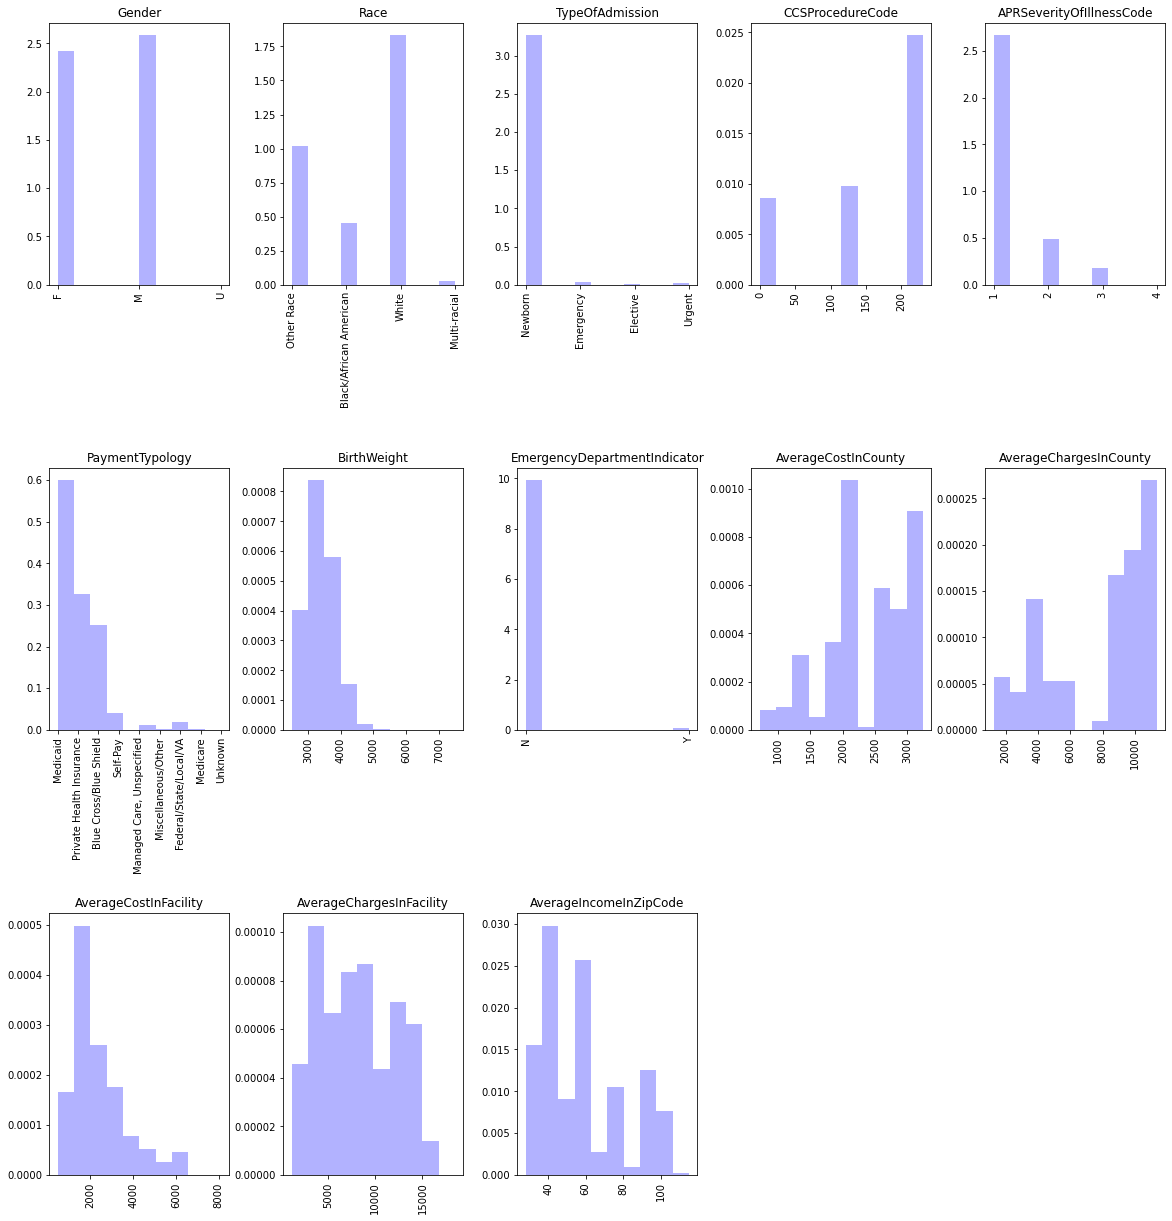

In [60]:
plt.figure(figsize=(20,20))
for i, col in enumerate(patients_X.columns):
    hist_plot(col, [patients_X[col]], ['b'], 3, 5, i+1)

###### 🧐 **Observations:**
> - Most categorical fields are not ordered. 
> - Categorical fields will need a numerical representation to be used in the ML model. 
> - For the field 'TypeOfAdmission', Emergency, Elective and Urgent are rare categories, most newborn babies have normal admissions as 'Newborn'.
> - Average Charges In Facility have very high values.
> - Rare categorical values:
    - Gender: Unknown 
    - Severity-of-illness-code: 4
    - EmergencyDepartmentIndicator: Yes 
    - PaymentTopology: SelfPay
    - PaymentTopology: Misc/Other
    - PaymentTopology: Medicare
    - PaymentTopology: Unknown 
    - TypeOfAdmission: Emergency  
> - TypeOfAdmission, the EmergencyDepartmentIndicator together shows that most hospital admissions were not emergencies.
| Column Name                  |      Observation
|:-----------------------------|:----------------------
| Gender                       |  Well distributed between 'M' and 'F', but 'U' is extremely under-represented.
| Race                         |  Not much data for multi-race newborns
| TypeOfAdmission              |  Bias towards 'Newborn' value, don't have much data on the other forms of admissions.
| CCSProcedureCode             |  Bias to codes in 200 area
| APRSeverityOfIllnessCode     |  Bias to code 1, right-skewed distribution
| PaymentTypology              |  Contais small values in some categories, not much representation.
| BirthWeight                  |  right-skewed distribution
| EmergencyDepartmentIndicator |  Extremely Bias to No
| AverageCostInCounty          |  left-skewed distribution, contains odd gap in data
| AverageChargesInCounty       |  left-skewed distribution, contains odd gap in data
| AverageCostInFacility        |  right-skewed distribution
| AverageChargesInFacility     |  slight right-skew distribution
| AverageIncomeInZipCode       |  right-skewed distribution
###### 👨🏻‍🎓 Conclusions
> - Average Charges In Facility shows that numeric values will need to be scaled i.e MinMax or other 
> - The Skewed data fields will need to be normalised. i.e PowerTransformer or other transformers.

###### 1.1.3 - Visualising Outliers in the Data
Following on from the conclusion made in 1.1.2, the fields here will be examined for outliers.

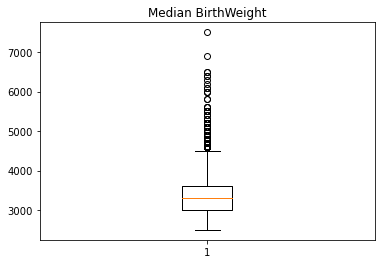

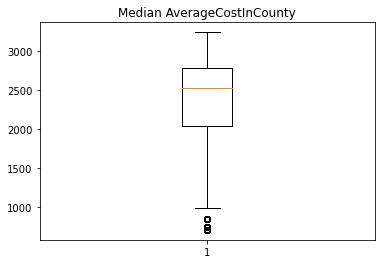

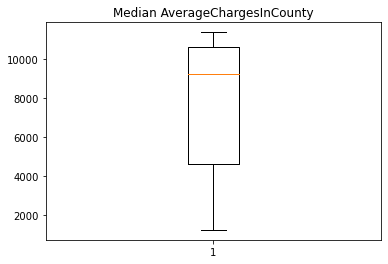

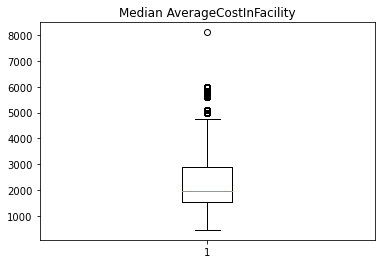

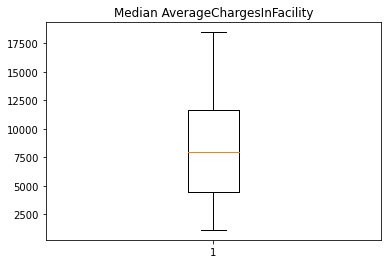

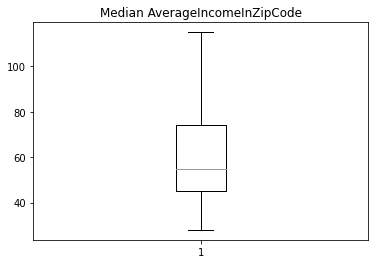

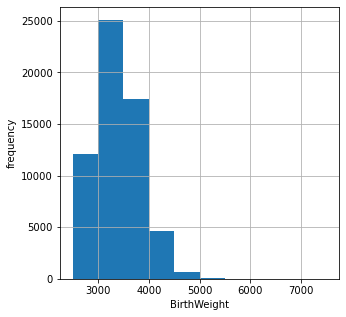

In [61]:
skewedFieldsObserved = ['BirthWeight', 'AverageCostInCounty', 'AverageChargesInCounty', 'AverageCostInFacility', 'AverageChargesInFacility', 'AverageIncomeInZipCode']
for field in skewedFieldsObserved:
    plt.boxplot(dataFrame[field])
    plt.title('Median ' + field)
    plt.show()

# Focusing on birth weight and seeing the ordinal categorical nature of the data.
dataFrame['BirthWeight'].hist(figsize=(5,5))
plt.xlabel('BirthWeight')
plt.ylabel('frequency')
plt.show()

###### 🧐 **Observations:**
> - Out of all the numeric skewed fields, Birth weight, AverageCostInFacility, AverageCostInCounty are the only ones with noticable outliers from a median perspective. These are outliers that live outside of the median.
###### 👨🏻‍🎓 Conclusions
> - Both StandardScaler, MaxAbsScaler, MinMaxScaler are very sensitive to the presence of outliers. RobustScalar isn't because it is based on percentiles, look into this scalar.
> - Test if separate outlier clipping is desirable, with techniques like QuantileTransformer.

### 1.2  Cleaning the data
Based of the conclusions in 1.1, here we delete/prune the tiny categories, remove single value categories.

Original Unknown Genders: 1
Original Illness Code 4: 1
(59966, 16)
New Unknown Genders: 0
New of Illness Code 4: 0
(59964, 13)


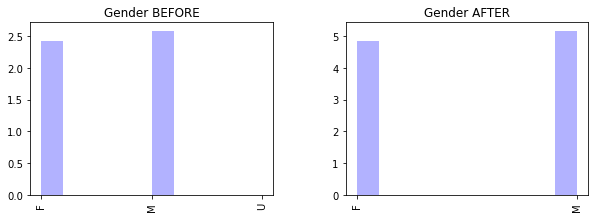

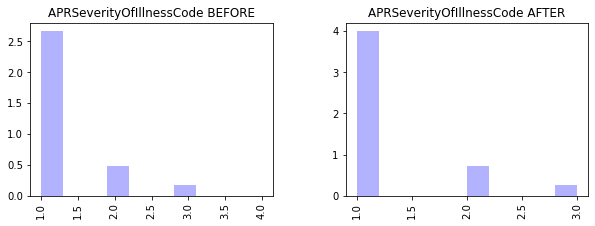

In [62]:
print("Original Unknown Genders: " + str(len(patients_X[patients_X.Gender == 'U'])))
print("Original Illness Code 4: " + str(len(patients_X[patients_X.APRSeverityOfIllnessCode == 4])))
print(raw_dataFrame.shape)

plt.figure(figsize=(10, 3))

hist_plot('Gender BEFORE', [patients_X['Gender']], ['b'], 1, 2, 1)
index1 = patients_X[patients_X.Gender == 'U'].index[0]
patients_X = patients_X.drop(index=index1)
patients_Y = patients_Y.drop(index=index1)
hist_plot("Gender AFTER", [patients_X['Gender']], ['b'], 1, 2, 2)

plt.figure(figsize=(10,3))
hist_plot('APRSeverityOfIllnessCode BEFORE', [patients_X['APRSeverityOfIllnessCode']], ['b'], 1, 2, 1)
index2 = patients_X[patients_X.APRSeverityOfIllnessCode == 4].index[0]
patients_X = patients_X.drop(index=index2)
patients_Y = patients_Y.drop(index=index2)
hist_plot("APRSeverityOfIllnessCode AFTER", [patients_X['APRSeverityOfIllnessCode']], ['b'], 1, 2, 2)


print("New Unknown Genders: " + str(len(patients_X[patients_X.Gender == 'U'])))
print("New of Illness Code 4: " + str(len(patients_X[patients_X.APRSeverityOfIllnessCode == 4])))
print(patients_X.shape)

### 1.3 - Correlations in the data
In this section we try find correlations with the refined data.

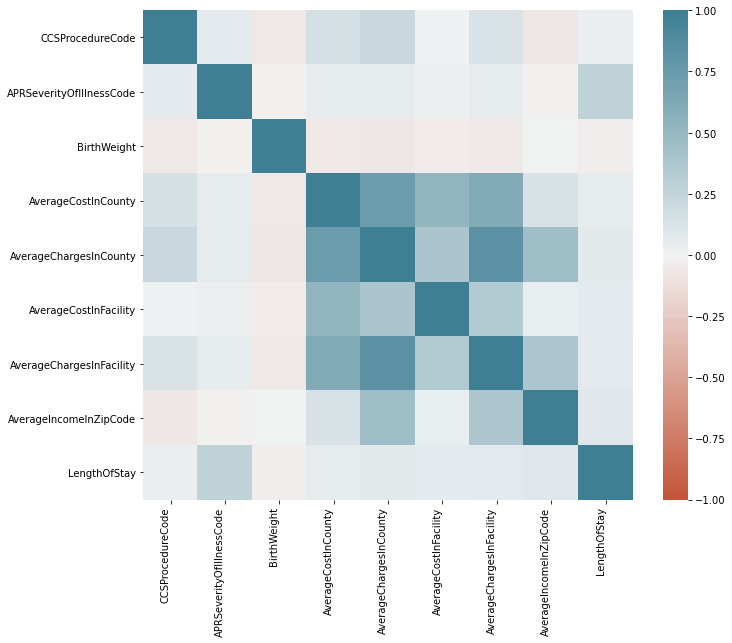

In [42]:
# This code was taken from week 5 lab, as is not this authors.
f, ax = plt.subplots(figsize=(11, 9))
corr = dataFrame.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

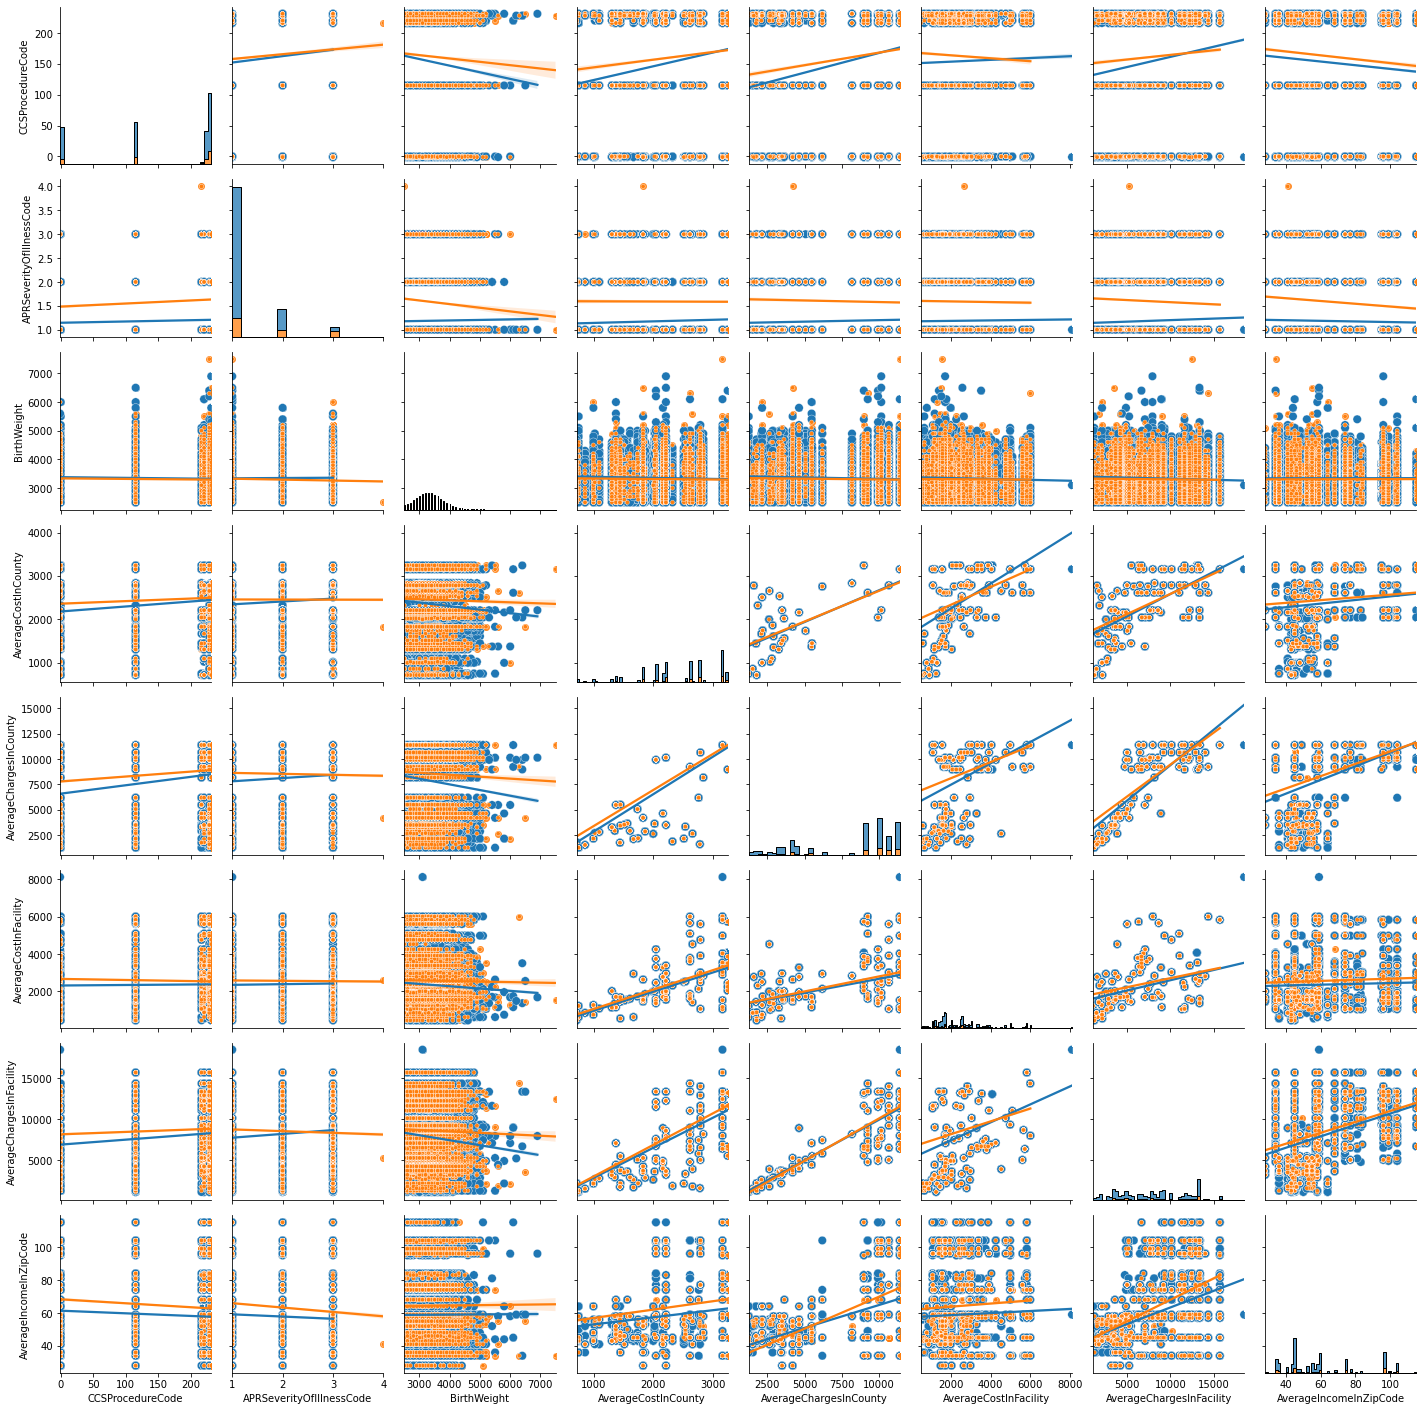

In [43]:
g = sns.PairGrid(dataFrame, hue="LengthOfStay")
g.map_offdiag(sns.regplot)
g.map_diag(sns.histplot, multiple="stack", element="step")
g.map_offdiag(sns.scatterplot, size=dataFrame["LengthOfStay"])


###### 🧐 **Observations:**
> - There isn't any obvious correlations that seperate LengthOfStay, between blue or orange. 
> - In most data points there is both blue and orange, meaning that length of stay has not be seperately very well between different correlations.

###### 👨🏻‍🎓 Conclusions
> - 

Check for Nan Data - DONE

Remove bad data with
Do PowerTransformer
Do MinMax Transform
Do the other transform


Do splitting by train, validation, test
Do splitting by K-fold K=5

Check split has equal values .shape()

Do the onehot encoding - Non Orderly Categorical
Do Dummy Encoding

Do Logistic Regression
Do Tree
Do the advanced Tree


Do F1 Score, Accuracy Score, Precision Score, R... Score

Do the feature importance

Show precision is affected if data is not weighted evenly, Show massive bias, one sided data, evenly weight it.

Do the hyper parameter tuning using random and graphical



### 1.3 - Data Splitting

###### 1.3.1 K-Fold

In [47]:
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold

# prepare cross validation
kfold = KFold(n_splits=2, random_state=None, shuffle=False)
# enumerate splits
for train_index, test_index in kfold.split(patients_X):
    print('train: %s, test: %s' % (dataFrame[train], dataFrame[test]))
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = patients_X[train_index], patients_X[test_index]
    y_train, y_test = patients_Y[train_index], patients_Y[test_index]

C:\Users\soldi\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


KeyError: "None of [Int64Index([    0,     1,     4,     5,     6,     7,     8,     9,    13,\n               14,\n            ...\n            59953, 59954, 59955, 59956, 59957, 59958, 59959, 59963, 59964,\n            59965],\n           dtype='int64', length=39977)] are in the [columns]"

###### 1.3.2 Hold out validation


In [63]:
from sklearn.model_selection import train_test_split

def holdout_validation(train_size):
    
    # 80% train = 20% Test, Split into 10% Validation & 10% Test, after
    test_size = 1 - train_size
    
    # Split into train and test for normal and target fields set, 20% is for validation and test.
    with pd.option_context('mode.chained_assignment', None):
        train_X, patients_X_test_, train_Y, patients_Y_test_ = train_test_split(patients_X, patients_Y, test_size=test_size, shuffle=True,random_state=0)

    # Split the test data into validation test and test.
    # Do for target field and normal fields.
    with pd.option_context('mode.chained_assignment', None):
         val_X, test_X, val_Y, test_Y = train_test_split(patients_X_test_, patients_Y_test_, test_size=0.5,
                                                shuffle=True,random_state=29)
    return train_X, val_X, test_X, train_Y, val_Y, test_Y

train_X, val_X, test_X, train_Y, val_Y, test_Y = holdout_validation(0.8)

###### 🧐 **Observations:**
> - The data seems to be fairly evenly split.

###### 👨🏻‍🎓 Conclusions
> - 

### 1.4 - Data Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode():
    # One-hot encode categorical features only
    for column in categorical_features:
        hot_encoder = OneHotEncoder(handle_unknown='ignore')
        hot_encoder.fit(patients_x_train_scaled[[column]])

        # Encode the training set
        transformed_train_cols = hot_encoder.transform(patients_x_train_scaled[[column]]).toarray()
        for i in range(len(hot_encoder.categories_[0])):
            patients_x_train_scaled[column + '_' + str(hot_encoder.categories_[0][i])] = transformed_train_cols[:,i]

        # Encode the testing set
        transformed_test_cols = hot_encoder.transform(patients_x_test_scaled[[column]]).toarray()
        for i in range(len(hot_encoder.categories_[0])):
            patients_x_test_scaled[column + '_' + str(hot_encoder.categories_[0][i])] = transformed_test_cols[:,i]

### 1.5 - Feature Scaling

#### Correcting training and test sets.
It is important to characterize what are normal and abnormal observations in the data.

In [ ]:

mm_patients_x_train_scaled = patients_X_train.copy()
mm_patients_x_test_scaled = patients_X_test.copy()

# Scale continuous noncategorical features using minmax TODO Why Minmax scaler and not powerscaling?
minmaxscaler = MinMaxScaler().fit(mm_patients_x_train_scaled.loc[:, noncategorical_features])
mm_patients_x_train_scaled.loc[:, noncategorical_features] = minmaxscaler.transform(mm_patients_x_train_scaled.loc[:, noncategorical_features])
mm_patients_x_test_scaled.loc[:, noncategorical_features] = minmaxscaler.transform(mm_patients_x_test_scaled.loc[:, noncategorical_features])

In [ ]:

pt_patients_x_train_scaled = patients_X_train.copy()
pt_patients_x_test_scaled = patients_X_test.copy()

powerTransformer = PowerTransformer(method='yeo-johnson').fit(pt_patients_x_train_scaled.loc[:, noncategorical_features])
pt_patients_x_train_scaled.loc[:, noncategorical_features] = powerTransformer.transform(pt_patients_x_train_scaled.loc[:, noncategorical_features])
pt_patients_x_test_scaled.loc[:, noncategorical_features] = powerTransformer.transform(pt_patients_x_test_scaled.loc[:, noncategorical_features])

In [ ]:
# Show the training set and the test sets overlayed in histogram format.
plt.figure(figsize=(20,20))
for i, col in enumerate(noncategorical_features):
    # 3 x 5 grid size, blue for training set, red for test set.
    hist_plot(col, [pt_patients_x_train_scaled[col], pt_patients_x_test_scaled[col]], ['b', 'r'], 3, 5, i+1)

In [65]:
def transform(scalar, field, datasets):
    t_datasets = []
    for dataset in datasets:
        t_datasets.add(scalar.transform(dataset[[field]]))
    return t_datasets

def scalingTest(row, field, datasets):
    # Get train data in the dataset.
    train = datasets[0][[field]]
    scalars = [
        ("MinMaxScalar", MinMaxScaler().fit(train)),
        ("StandardScaler", StandardScaler().fit(train)),
        ("MaxAbsScaler", MaxAbsScaler().fit(train)),
        ("RobustScaler", RobustScaler(quantile_range=(25, 75)).fit(train)),
        ("PowerTransformer", PowerTransformer(method='yeo-johnson').fit(train)),
        ("QuantileTransformer", QuantileTransformer(output_distribution='normal').fit(train)),
        ("Normalizer", Normalizer().fit(train))
    ]
    
    plt.figure(figsize=(35,5))    
    for index, scalar in scalars:
        dataset = transform(scalar[1], field, datasets)
        plt.subplot(row, len(scalars), index + 1)
        plt.hist(dataset, alpha=0.3, color='r', density=True)
        plt.title(scalar[0])

    plt.show()

scalingTest(1, "BirthWeight", [train_X, val_X, test_X])


C:\Users\soldi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


TypeError: 'MinMaxScaler' object is not subscriptable

<Figure size 2520x360 with 0 Axes>

In [ ]:
# Drop original columns because they are now represented in the dataframe by the new one hot encoded columns.
patients_x_train_scaled = patients_x_train_scaled.drop(categorical_features, axis=1)
patients_x_test_scaled = patients_x_test_scaled.drop(categorical_features, axis=1)

In [ ]:
plt.figure(figsize=(20,20))
for i, col in enumerate(patients_x_train_scaled.columns):
    hist_plot(col, [patients_x_train_scaled[col], patients_x_test_scaled[col]], ['b', 'r'], 7, 7, i+1)

In [ ]:
import seaborn as sns

g = sns.PairGrid(patients_x_train_scaled, vars=patients_x_train_scaled.columns, hue="LengthOfStay")
g.map(sns.scatterplot)
plt.show()

# 6 - Methodology Selection
As discussed in the EDA, this problem is a classification problem. The models that are classification models are:
 - Logistical Regression
 - Decision Tree
 - Naive Bayes
 - Random Forest

These will be the selection of models to analyse.

### Regularised Polynomial Logistic Regression Model 
Here I experiement using one of the restricted models we have learnt so far. \
In the EDA we can see that a non-linear decision boundaries could put to work some of the birthweight field values. The data is very hard to seperate and so I do not expect Logistic Regression to do well with this data. However, when it comes to the charges in facility and charges in county, there is some good correlation. With those correlated fields, regularisation could possibly be justified.

### Decision Tree
This classification model is known to overfit. The more features the more likely it will overfit, this is one that needs a validation adn test set to check for overfitting. For this reason we will be using the Hold out validation split.

In [ ]:
from sklearn import tree

tree_max_depth = 2   #change this value and observe

clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=tree_max_depth, class_weight='balanced')
clf = clf.fit(train_X, train_y)
Dtree = get_tree_2_plot(clf)
Dtree

train_acc, val_acc = get_acc_scores(clf,train_X, train_y, val_X, val_y)
print("Train f1 score: {:.3f}".format(train_acc))
print("Validation f1 score: {:.3f}".format(val_acc))

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

### Random Forest

### **Experiment Setup**
Setup the test/validation data, visualisers and debuggers needed to determine bottlenecks in performance (overfitting/under-fitting, feature importance).

**Default Baseline Model**: Identify the components of end-to-end pipeline including - Baseline Models, cost functions, optimisation.

**Make incremental changes**: Repeatedly make incremental changes such as gathering new data, adjusting hyper-parameters, or changing algorithms, based on specific findings from your instrumentation.

# 7 - Hyper Parameter Selection Strategy

# 8 - Performance Evaluation Metric
Based off the conclusions found in 1.1, the evalutation metrics that will be used are:\
For logistic regression:
- MLA
- MSA

For all Models:
- Accuracy
- Precision
- Recall
- F1 Score

In [ ]:
from sklearn.metrics import f1_score

def get_f1_scores(clf, train_X, train_y, val_X, val_y):
    train_pred = clf.predict(train_X)
    val_pred = clf.predict(val_X)
    
    train_f1 = f1_score(train_y, train_pred, average='macro')
    val_f1 = f1_score(val_y, val_pred, average='macro')
    
    return train_f1, val_f1

In [ ]:
patients_x_test_scaled.head()

Use Regularisation because the fields are highly correlated

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model_lr, dailyBike_x_test_scaled, dailyBike_y_test, n_repeats=30)
inx = np.argsort(r.importances_mean)

fig = plt.figure(figsize=(10,10))
plt.barh(dailyBike_x_test_scaled.columns[inx], r.importances_mean[inx])
plt.xticks(rotation='vertical')
fig.show()

# Questions to Answer
What is the range of some of the attributes?
Which of the features have a very different average to the others?
Which feature is skewed (hint examine the histogram)?
Which features are highly correlated?

### Approach
##### Requirements & Restrictions for this project
To start off there were some requirements and restrictions for project:
xcv

##### Data Exploration
Ordinal categorical features
Nominal categorical features

Continuous Numerical features - Decimal
Discrete numerical features - Integers
##### Evaluation Framework

##### Methodology Selection

##### Hyper Parameter Selection Strategy
Random method, graph method, or the
##### Model Analyses


### Ultimate Judgment & Analysis

